In [1]:
# Cell 1: Setup Logging and Load Prepared Datasets

import logging
import sys
import os
import pandas as pd

LOG_FILE = "extreme_facilities_analysis.log"

logging.basicConfig(
    level=logging.INFO,
    filename=LOG_FILE,
    filemode="w",  # Overwrite previous logs on each run
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger()

# Redirect print statements to logger
class LoggerWriter:
    def __init__(self, level):
        self.level = level
    def write(self, message):
        if message.strip():
            self.level(message.strip())
    def flush(self):
        pass

sys.stdout = LoggerWriter(logger.info)
sys.stderr = LoggerWriter(logger.error)

print("=== Logging Setup Complete ===")

# Define path to prepared datasets (adjust if necessary)
PREPARED_PATH = "./data/prepared/"

# Dictionary mapping dataset names to their file names
files = {
    "pbj_nurse": "pbj_nurse_prepared.parquet",
    "pbj_non_nurse": "pbj_non_nurse_prepared.parquet",
    "qrp_provider": "qrp_provider_prepared.parquet",
    "nh_survey": "nh_survey_prepared.parquet",
    "nh_quality_mds": "nh_quality_mds_prepared.parquet",
    "nh_ownership": "nh_ownership_prepared.parquet",
    "nh_citations": "nh_citations_prepared.parquet"
}

# Load datasets into a dictionary
loaded_datasets = {}
for key, filename in files.items():
    file_path = os.path.join(PREPARED_PATH, filename)
    try:
        loaded_datasets[key] = pd.read_parquet(file_path)
        print(f"Loaded {key} with shape {loaded_datasets[key].shape}")
    except Exception as e:
        print(f"Error loading {key}: {e}")


In [2]:
# Cell 2: Facility-Level Aggregation from pbj_nurse

# Work with the pbj_nurse dataset to compute total RN employee and contract hours per facility.
# Reset index if 'workdate' was used as index previously.
pbj_nurse = loaded_datasets['pbj_nurse'].copy()
if pbj_nurse.index.name == 'workdate':
    pbj_nurse.reset_index(inplace=True)

# Ensure workdate is datetime
pbj_nurse['workdate'] = pd.to_datetime(pbj_nurse['workdate'], errors='coerce')

# Aggregate data at the facility level using 'provnum'
facility_rn = pbj_nurse.groupby('provnum', as_index=False).agg({
    'hrs_rn_emp': 'sum',
    'hrs_rn_ctr': 'sum',
    'mdscensus': 'mean'  # average census for the facility
})
# Compute total RN hours and contract ratio
facility_rn['total_rn_hours'] = facility_rn['hrs_rn_emp'] + facility_rn['hrs_rn_ctr']
facility_rn['rn_temp_ratio'] = facility_rn['hrs_rn_ctr'] / (facility_rn['total_rn_hours'] + 1e-6)

print("Facility-level RN aggregation complete. Sample:")
print(facility_rn.head())


In [3]:
# Cell 3: Identify Top 1% Facilities for Contract Use

# Calculate threshold for top 1% contract hours (hrs_rn_ctr)
threshold_contract = facility_rn['hrs_rn_ctr'].quantile(0.99)
extreme_contract_facilities = facility_rn[facility_rn['hrs_rn_ctr'] >= threshold_contract]

print("Top 1% Facilities by RN Contract Hours:")
print(extreme_contract_facilities[['provnum', 'hrs_rn_ctr', 'rn_temp_ratio', 'total_rn_hours', 'mdscensus']].describe())

# Save list of extreme contract facilities for further analysis
extreme_contract_facilities_ids = extreme_contract_facilities['provnum'].unique()
print("Number of extreme contract facilities:", len(extreme_contract_facilities_ids))


In [4]:
# Cell 4: Identify Top 1% Facilities for Employee Use

# Calculate threshold for top 1% employee hours (hrs_rn_emp)
threshold_employee = facility_rn['hrs_rn_emp'].quantile(0.99)
extreme_employee_facilities = facility_rn[facility_rn['hrs_rn_emp'] >= threshold_employee]

print("Top 1% Facilities by RN Employee Hours:")
print(extreme_employee_facilities[['provnum', 'hrs_rn_emp', 'rn_temp_ratio', 'total_rn_hours', 'mdscensus']].describe())

# Save list of extreme employee facilities for further analysis
extreme_employee_facilities_ids = extreme_employee_facilities['provnum'].unique()
print("Number of extreme employee facilities:", len(extreme_employee_facilities_ids))


In [5]:
# Cell 5: Merge Additional Information from Other CMS Datasets

# We'll merge facility-level RN data with the additional datasets to gather more information.

# 5A: Merge with qrp_provider (Quality Reporting Program)
qrp_provider = loaded_datasets['qrp_provider'].copy()
qrp_provider.rename(columns={'cms_certification_number_(ccn)': 'provnum'}, inplace=True)
# Convert provnum to string for safe merging
qrp_provider['provnum'] = qrp_provider['provnum'].astype(str)
facility_rn['provnum'] = facility_rn['provnum'].astype(str)

facility_rn_quality = pd.merge(facility_rn, qrp_provider, on='provnum', how='left')
print("Merged facility RN data with qrp_provider. Sample:")
print(facility_rn_quality.head())

# 5B: Merge with nh_survey (Survey Deficiencies)
nh_survey = loaded_datasets['nh_survey'].copy()
nh_survey.rename(columns={'cms_certification_number_(ccn)': 'provnum'}, inplace=True)
nh_survey['provnum'] = nh_survey['provnum'].astype(str)
facility_rn_survey = pd.merge(facility_rn, nh_survey[['provnum', 'total_number_of_health_deficiencies']], on='provnum', how='left')
facility_rn_survey['total_number_of_health_deficiencies'] = facility_rn_survey['total_number_of_health_deficiencies'].fillna(0)
print("Merged facility RN data with nh_survey deficiencies. Sample:")
print(facility_rn_survey.head())

# 5C: Merge with nh_quality_mds (Quality Measures)
nh_quality = loaded_datasets['nh_quality_mds'].copy()
nh_quality.rename(columns={'cms_certification_number_(ccn)': 'provnum'}, inplace=True)
nh_quality['provnum'] = nh_quality['provnum'].astype(str)
facility_rn_quality_mds = pd.merge(facility_rn, nh_quality[['provnum', 'four_quarter_average_score']], on='provnum', how='left')
facility_rn_quality_mds['four_quarter_average_score'] = pd.to_numeric(facility_rn_quality_mds['four_quarter_average_score'], errors='coerce')
print("Merged facility RN data with nh_quality_mds. Sample:")
print(facility_rn_quality_mds.head())

# 5D: Merge with nh_ownership (Ownership Information)
nh_ownership = loaded_datasets['nh_ownership'].copy()
nh_ownership.rename(columns={'cms_certification_number_(ccn)': 'provnum'}, inplace=True)
nh_ownership['provnum'] = nh_ownership['provnum'].astype(str)
facility_rn_ownership = pd.merge(facility_rn, nh_ownership, on='provnum', how='left')
print("Merged facility RN data with nh_ownership. Sample:")
print(facility_rn_ownership.head())

# 5E: Merge with nh_citations (Citations/penalties)
nh_citations = loaded_datasets['nh_citations'].copy()
nh_citations.rename(columns={'cms_certification_number_(ccn)': 'provnum'}, inplace=True)
nh_citations['provnum'] = nh_citations['provnum'].astype(str)
# For simplicity, count number of citations per facility
facility_citations = nh_citations.groupby('provnum', as_index=False).size().rename(columns={'size':'citation_count'})
facility_rn_citations = pd.merge(facility_rn, facility_citations, on='provnum', how='left')
facility_rn_citations['citation_count'] = facility_rn_citations['citation_count'].fillna(0)
print("Merged facility RN data with nh_citations. Sample:")
print(facility_rn_citations.head())


In [6]:
# Cell 6: Characterize Extreme Facilities (Top 1% Contract and Top 1% Employee)

# We assume that facility_rn_quality, facility_rn_survey, facility_rn_quality_mds, and facility_rn_ownership have been merged as in Cell 5.

# For extreme contract use:
extreme_contract_info = facility_rn_quality[facility_rn_quality['provnum'].isin(extreme_contract_facilities_ids)]
extreme_contract_info = pd.merge(extreme_contract_info, facility_rn_survey[['provnum', 'total_number_of_health_deficiencies']], on='provnum', how='left')
extreme_contract_info = pd.merge(extreme_contract_info, facility_rn_quality_mds[['provnum', 'four_quarter_average_score']], on='provnum', how='left')
extreme_contract_info = pd.merge(extreme_contract_info, facility_rn_ownership[['provnum', 'owner_type', 'state']], on='provnum', how='left')

print("Characteristics of Facilities in the Top 1% of RN Contract Use:")
print(extreme_contract_info.describe(include='all'))

# For extreme employee use:
extreme_employee_info = facility_rn_quality[facility_rn_quality['provnum'].isin(extreme_employee_facilities_ids)]
extreme_employee_info = pd.merge(extreme_employee_info, facility_rn_survey[['provnum', 'total_number_of_health_deficiencies']], on='provnum', how='left')
extreme_employee_info = pd.merge(extreme_employee_info, facility_rn_quality_mds[['provnum', 'four_quarter_average_score']], on='provnum', how='left')
extreme_employee_info = pd.merge(extreme_employee_info, facility_rn_ownership[['provnum', 'owner_type', 'state']], on='provnum', how='left')

print("Characteristics of Facilities in the Top 1% of RN Employee Use:")
print(extreme_employee_info.describe(include='all'))


In [7]:
# Check column names to identify where 'state' ended up
print("Extreme Contract Use DataFrame Columns:")
print(extreme_contract_info.columns)

print("\nExtreme Employee Use DataFrame Columns:")
print(extreme_employee_info.columns)


In [8]:
import pandas as pd

# Checking differences in state columns for Extreme Contract Use
contract_state_comparison = extreme_contract_info[['state_x', 'state_y']].drop_duplicates()
print("Extreme Contract Use - Unique State Comparisons:")
print(contract_state_comparison)

# Checking differences in state columns for Extreme Employee Use
employee_state_comparison = extreme_employee_info[['state_x', 'state_y']].drop_duplicates()
print("\nExtreme Employee Use - Unique State Comparisons:")
print(employee_state_comparison)

# Checking mismatches in Extreme Contract Use
contract_state_mismatches = extreme_contract_info[extreme_contract_info['state_x'] != extreme_contract_info['state_y']]
print("\nExtreme Contract Use - Mismatches:")
print(contract_state_mismatches[['provnum', 'state_x', 'state_y']])

# Checking mismatches in Extreme Employee Use
employee_state_mismatches = extreme_employee_info[extreme_employee_info['state_x'] != extreme_employee_info['state_y']]
print("\nExtreme Employee Use - Mismatches:")
print(employee_state_mismatches[['provnum', 'state_x', 'state_y']])


In [9]:
# Drop redundant state_y and rename state_x to 'state'
extreme_contract_info = extreme_contract_info.drop(columns=['state_y']).rename(columns={'state_x': 'state'})
extreme_employee_info = extreme_employee_info.drop(columns=['state_y']).rename(columns={'state_x': 'state'})

# Confirm the changes
print("Updated columns for Extreme Contract Use:")
print(extreme_contract_info.columns)

print("\nUpdated columns for Extreme Employee Use:")
print(extreme_employee_info.columns)


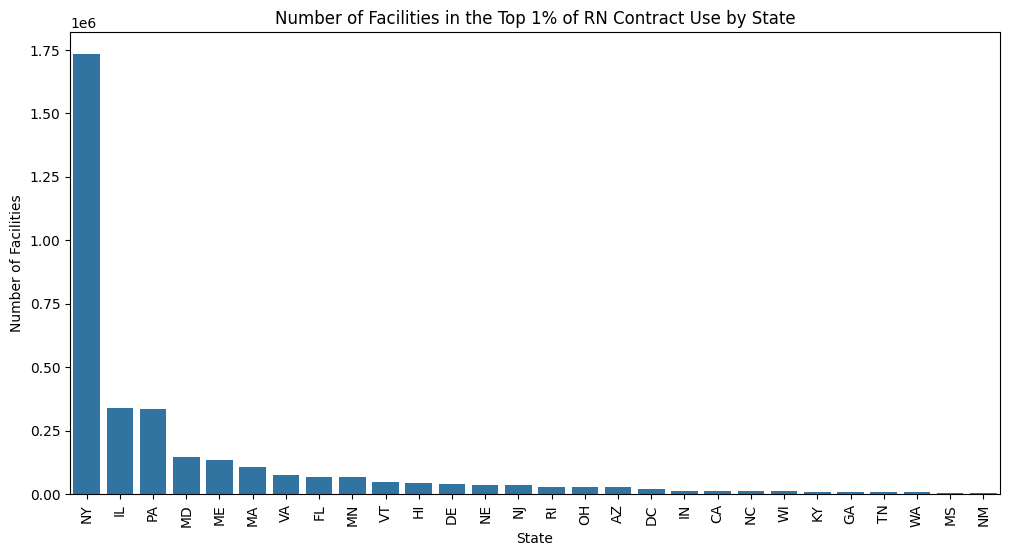

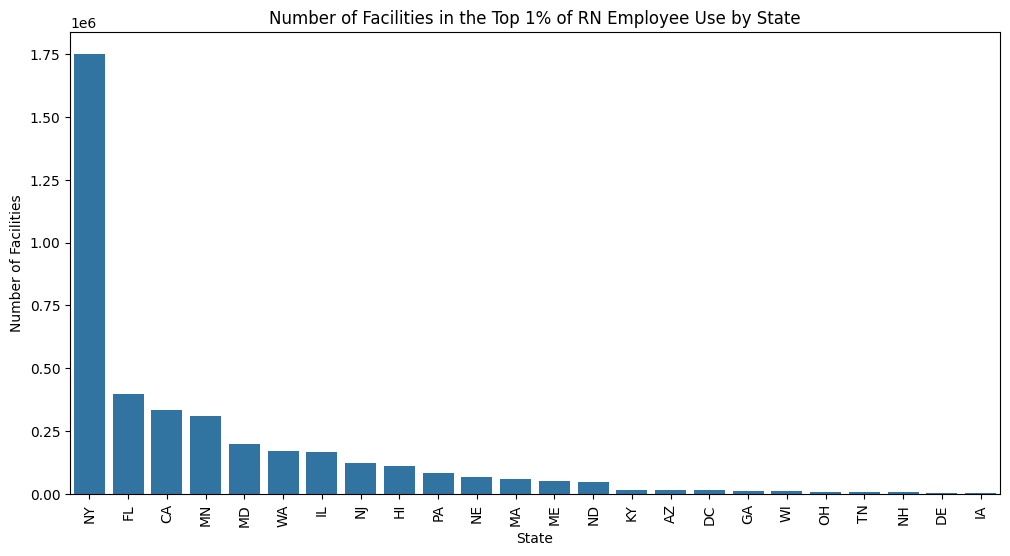

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of facilities per state for extreme contract use
contract_state_counts = extreme_contract_info['state'].value_counts().reset_index()
contract_state_counts.columns = ['state', 'facility_count']

# Count of facilities per state for extreme employee use
employee_state_counts = extreme_employee_info['state'].value_counts().reset_index()
employee_state_counts.columns = ['state', 'facility_count']

# Plot for extreme contract use
plt.figure(figsize=(12,6))
sns.barplot(x=contract_state_counts['state'], y=contract_state_counts['facility_count'])
plt.title("Number of Facilities in the Top 1% of RN Contract Use by State")
plt.xlabel("State")
plt.ylabel("Number of Facilities")
plt.xticks(rotation=90)
plt.show()

# Plot for extreme employee use
plt.figure(figsize=(12,6))
sns.barplot(x=employee_state_counts['state'], y=employee_state_counts['facility_count'])
plt.title("Number of Facilities in the Top 1% of RN Employee Use by State")
plt.xlabel("State")
plt.ylabel("Number of Facilities")
plt.xticks(rotation=90)
plt.show()


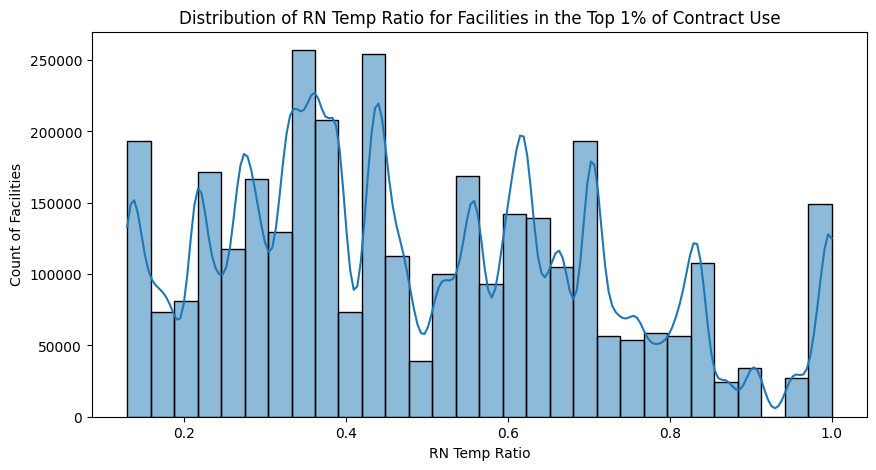

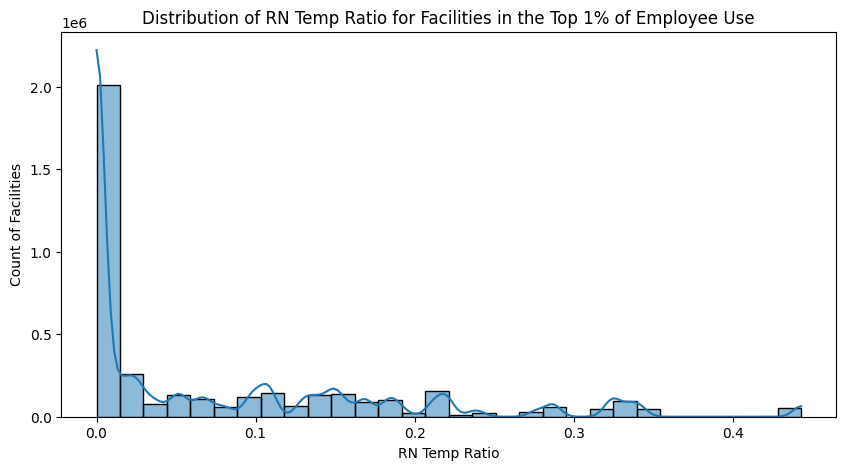

In [11]:
# Plot RN temp ratio distribution for extreme contract use
plt.figure(figsize=(10,5))
sns.histplot(extreme_contract_info['rn_temp_ratio'], bins=30, kde=True)
plt.title("Distribution of RN Temp Ratio for Facilities in the Top 1% of Contract Use")
plt.xlabel("RN Temp Ratio")
plt.ylabel("Count of Facilities")
plt.show()

# Plot RN temp ratio distribution for extreme employee use
plt.figure(figsize=(10,5))
sns.histplot(extreme_employee_info['rn_temp_ratio'], bins=30, kde=True)
plt.title("Distribution of RN Temp Ratio for Facilities in the Top 1% of Employee Use")
plt.xlabel("RN Temp Ratio")
plt.ylabel("Count of Facilities")
plt.show()


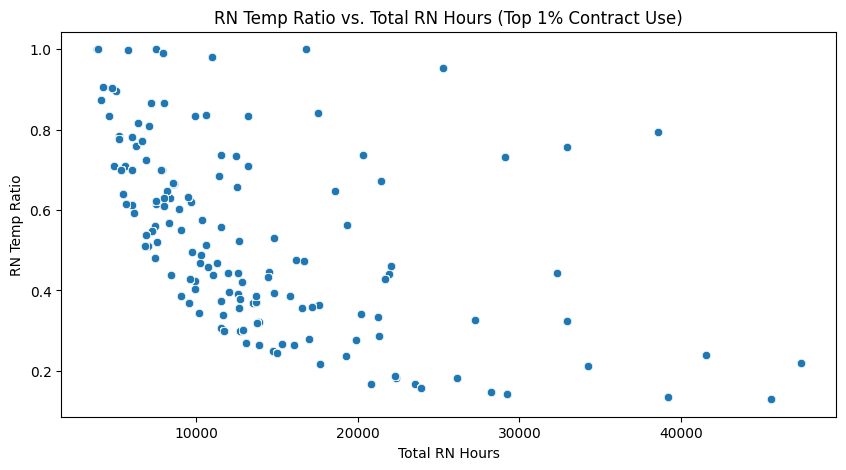

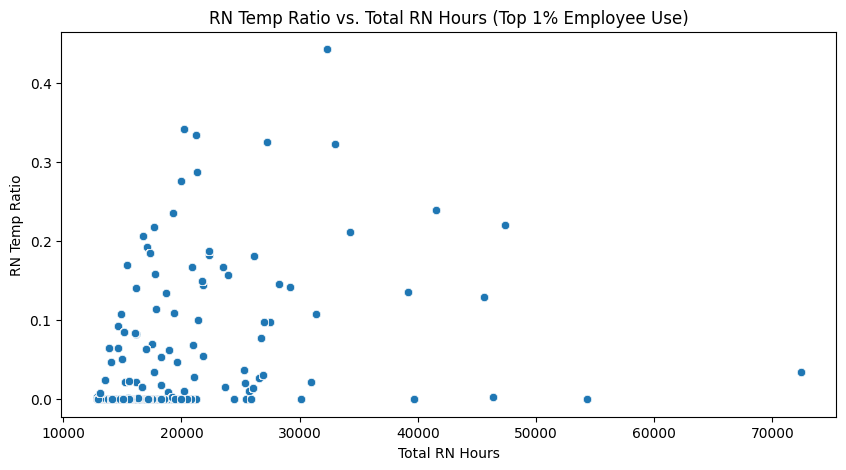

In [12]:
# Scatter plot for extreme contract use
plt.figure(figsize=(10,5))
sns.scatterplot(x=extreme_contract_info['total_rn_hours'], y=extreme_contract_info['rn_temp_ratio'])
plt.title("RN Temp Ratio vs. Total RN Hours (Top 1% Contract Use)")
plt.xlabel("Total RN Hours")
plt.ylabel("RN Temp Ratio")
plt.show()

# Scatter plot for extreme employee use
plt.figure(figsize=(10,5))
sns.scatterplot(x=extreme_employee_info['total_rn_hours'], y=extreme_employee_info['rn_temp_ratio'])
plt.title("RN Temp Ratio vs. Total RN Hours (Top 1% Employee Use)")
plt.xlabel("Total RN Hours")
plt.ylabel("RN Temp Ratio")
plt.show()


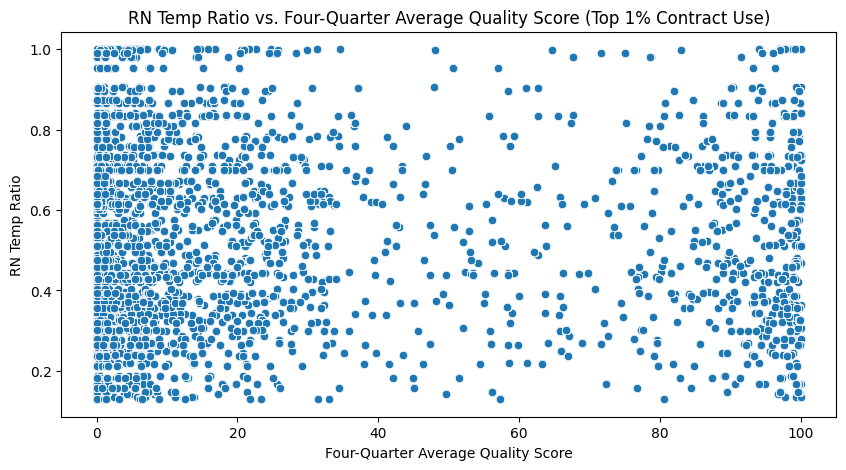

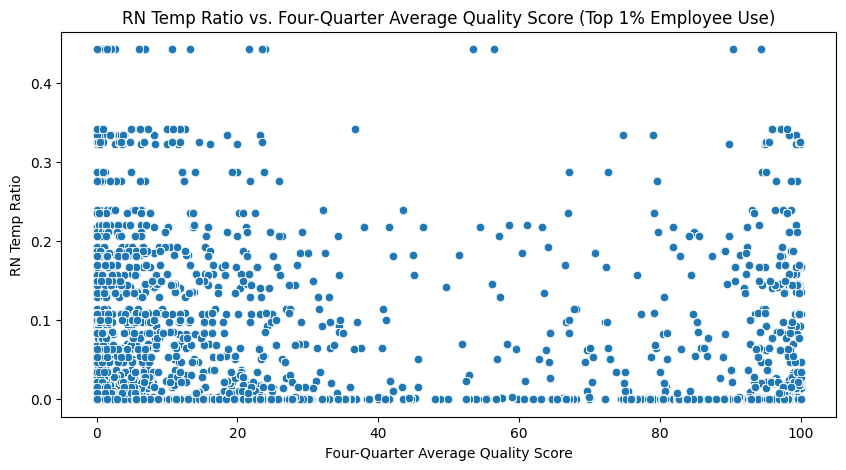

In [13]:
# Scatter plot for extreme contract use
plt.figure(figsize=(10,5))
sns.scatterplot(x=extreme_contract_info['four_quarter_average_score'], y=extreme_contract_info['rn_temp_ratio'])
plt.title("RN Temp Ratio vs. Four-Quarter Average Quality Score (Top 1% Contract Use)")
plt.xlabel("Four-Quarter Average Quality Score")
plt.ylabel("RN Temp Ratio")
plt.show()

# Scatter plot for extreme employee use
plt.figure(figsize=(10,5))
sns.scatterplot(x=extreme_employee_info['four_quarter_average_score'], y=extreme_employee_info['rn_temp_ratio'])
plt.title("RN Temp Ratio vs. Four-Quarter Average Quality Score (Top 1% Employee Use)")
plt.xlabel("Four-Quarter Average Quality Score")
plt.ylabel("RN Temp Ratio")
plt.show()
